# K-Means Clustering

K-Means is an unsupervised machine learning algorithm used for clustering data into distinct groups. It aims to partition a dataset into `k` clusters, where each data point belongs to the cluster with the nearest centroid.

### How It Works:
1. **Initialization**: Select `k` initial cluster centroids randomly or using a specific heuristic.
2. **Assignment Step**: Assign each data point to the nearest cluster centroid based on a distance metric (e.g., Euclidean distance).
3. **Update Step**: Recalculate the centroids as the mean of all data points assigned to each cluster.
4. **Repeat**: Iterate the assignment and update steps until the centroids stabilize (i.e., no significant change) or a maximum number of iterations is reached.

### Limitations:
- Requires the number of clusters (`k`) to be specified in advance, although there are ways to score a classification and use the k-value with the best score, penalizing both the distance of points from the centroid and the number of clusters.
- Sensitive to outliers and initial centroid placement.
- Assumes clusters are spherical-ish and equally sized, which may not always hold true.

In [98]:
# this section adds the package path to the system path so it can be used here
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))


import mltoolbox as ml # my module

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [99]:
# Load the CSV file into a pandas DataFrame
D = pd.read_csv('../../Datasets/seeds_dataset.csv', delimiter=r'\s+', names=[
    'area',
    'perimeter', 
    'compactness', 
    'length_of_kernel', 
    'width_of_kernel', 
    'asymmetry', 
    'length_of_kernel_groove', 
    'class'])


# so our lable is the class column,
y = D['class'].to_numpy()
X = D[['area', 'asymmetry']].values


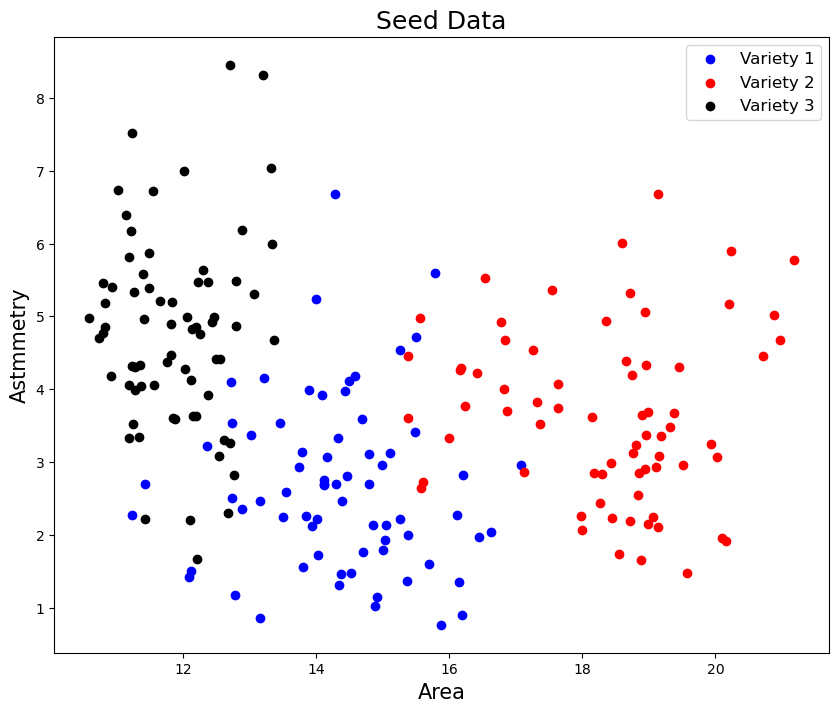

In [100]:
plt.figure(figsize=(10, 8))
plt.title("Seed Data", fontsize=18)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Variety 1')
plt.scatter(X[y == 2, 0], X[y == 2, 1], c='red', label='Variety 2')
plt.scatter(X[y == 3, 0], X[y == 3, 1], c='black', label='Variety 3')
plt.xlabel("Area", fontsize=15)
plt.ylabel("Astmmetry", fontsize=15)
plt.legend(fontsize=12)
plt.show()

In [101]:
# this distance function we use
def distance(X, center): 
    return np.sqrt(sum((X[j] - center[j])**2 for j in range(len(X))))  

In [102]:
km = ml.kmeans(X,y,distance) # initialize an instance of the kmeans class from my module
km.make_centroids(3)
km.assign_label()


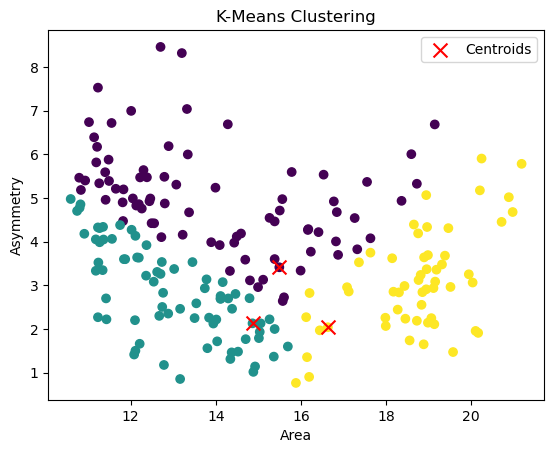

In [103]:
km.plot_spread('Area', 'Asymmetry')

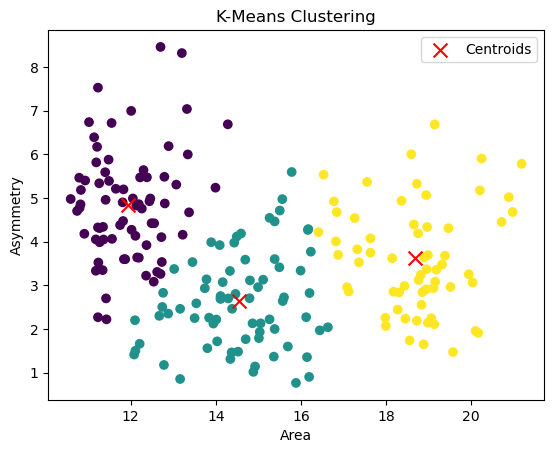

In [104]:
km.update_loop(20) # update the kmeans 20 times.
km.plot_spread('Area', 'Asymmetry')

# Basic K-means results

It works very well on this data set, quickly reaching what is close to the true groupings. But this is with a predetermined number of groupings given to it. To be truly unsupervised it needs to work with only the input data and decide on the number of clusters itself.

To do this, I will use the basic idea that we want densely packed data points near the center, and sparse regions near the edges. I can use k-nearest neighbors to determine a point's overlap with other regions. We will want to minimize the overlap from KNN. However, this will bias towards fewer just because they lead to there being less perimeter to overlap on.

To overcome this, I really want to minimize (KNN overlap)/(Total length of edges), but I will approximate it with (KNN overlap)/(Number of overlapping points).

In [105]:
def distance(x1,x2):
      return np.sqrt(sum([(x1[i]-x2[i])**2 for i in range(len(x1))]))


def k_nearest_neighbors(point, lable, X, y, k):
        # Create an empty list to store neighbors and distances
        neighbors = []

        
        for p, l in zip(X, y):
            d = distance(point, p)
            temp_data = [p, l, d]
            neighbors.append(temp_data)
  
            
        neighbors.sort(key=lambda x: x[-1])
        
        n = neighbors[:k]
        overlap = 0.0
        for nb in n:
              if nb[1]!=(lable) and nb[2]!=0:
                    overlap+= 1/nb[2]
            
        return overlap

### The group number decison

In the above cell there is the function that defines 'overlap' for each point. It is the sum of 1/(distance between points) for every k-nearest neighbor that is not in the same group as the point.

We take the sum of the overlaps for every point, and then to account for models with more clusters having more perimeters, we divide by 2*pi*sqrt(k) - pi. The idea behind this is that the data is a unit circle that then has its area didvided up into k circles. If each of the divided circles are the same size then we must have pi*(small radius)^2*k = pi, so r^2*k=1, so r = 1/sqrt(k). Each circle has a perimeter of 2*pi*r, so 2*pi/sqrt(k), and there are k circles, so there is s*pi*sqrt(k) small circle perimeter, and the outer edge of the large circle is not adjacent to anything and should not count, so we subtract pi and end up with:

$2*pi*sqrt(k) - pi$ 

As our estimator for the total perimeter. We then divide the total overlap by the total perimter to even the playing field between models.

The results are reasonably good, k=3 is lower than all of the nearby k-values and is a good choice for the model. However, sometimes the larger k-values like 6 or 8 get lower scores than k=3. They change significantly between iterations, so I cannot say they are a better choice than k=3 which is consitently low.

In [107]:

for k in range(2,9):
    km.make_centroids(k)
    km.assign_label()
    km.update_loop(1000)

    ol = 0.0

    for x,lable in zip(X,km.y_hat):
        i = k_nearest_neighbors(x,lable,X,km.y_hat,6)
        ol+=i

    overlap_per_perimeter = ol/(2*np.pi*np.sqrt(k)-np.pi)
    print(f"Overlap for k={k}: {overlap_per_perimeter}")

Overlap for k=2: 16.223566112896158
Overlap for k=3: 11.163440297400653
Overlap for k=4: 14.817632955882766
Overlap for k=5: 12.061760185163065
Overlap for k=6: 14.130221167637533
Overlap for k=7: 18.23537543475464
Overlap for k=8: 13.228586451097836
